# Installs (*only in first run*)

In [ ]:
!pip install rarfile

# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate, Activation
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio
import gdown
import rarfile

# Download Dataset (*only in first run*)

In [ ]:
dataset_url = "https://drive.google.com/file/d/16YpXUDbco9DAKS1-G-VcjgzWNuMQDwvW/view?usp=drive_link"
dataset_rar_path = "/content/IPProjectDataset24.rar"

file_id = dataset_url.split('/')[-2]
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset_rar_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=16YpXUDbco9DAKS1-G-VcjgzWNuMQDwvW
From (redirected): https://drive.google.com/uc?id=16YpXUDbco9DAKS1-G-VcjgzWNuMQDwvW&confirm=t&uuid=bccdbe0e-a62a-4172-a435-c3cdc9189923
To: /content/IPProjectDataset24.rar
100%|██████████| 423M/423M [00:09<00:00, 44.4MB/s]


'/content/IPProjectDataset24.rar'

# Extract Dataset RAR file (*only in first run*)



In [ ]:
extracted_path = "/content/IPProjectDataset24"
rf = rarfile.RarFile(dataset_rar_path)
rf.extractall(extracted_path)

# Full Code

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import rand_score

In [ ]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function /content/IPProjectDataset24/IPProjectDataset24/train_data/Images/seq10_000000.png /content/IPProjectDataset24/IPProjectDataset24/train_data/Labels/seq10_000000.png
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = os.listdir(maskPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        img = cv2.resize(img, (shape, shape))
        frameObj['img'].append(img)

    for i in range(len(maskNames)):
        mask = plt.imread(maskAddr + maskNames[i])
        mask = cv2.resize(mask, (shape, shape))
        frameObj['mask'].append(mask)

    return frameObj


In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/IPProjectDataset24/IPProjectDataset24/train_data/Images', maskPath = '/content/IPProjectDataset24/IPProjectDataset24/train_data/Labels'
         , shape = 256)

In [ ]:
framObjValidation  = LoadData( framObjValidation, imgPath = '/content/IPProjectDataset24/IPProjectDataset24/val_data/Images', maskPath = '/content/IPProjectDataset24/IPProjectDataset24/val_data/Labels'
         , shape = 256)

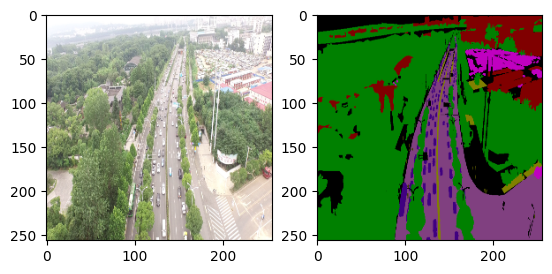

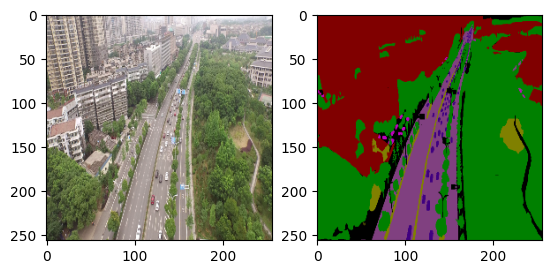

In [ ]:
## displaying train data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][0])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][0])
plt.show()

## displaying validation data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjValidation['img'][0])
plt.subplot(1,2,2)
plt.imshow(framObjValidation['mask'][0])
plt.show()


# Data Augmentaion

In [ ]:
# Convert the loaded data into NumPy arrays
train_images = np.array(framObjTrain['img'], dtype=np.float32)
train_masks = np.array(framObjTrain['mask'], dtype=np.float32)
val_images = np.array(framObjValidation['img'], dtype=np.float32)
val_masks = np.array(framObjValidation['mask'], dtype=np.float32)

In [ ]:
# Data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1.0)

# Create generators
train_generator = train_datagen.flow(train_images, train_masks, batch_size=16)
val_generator = validation_datagen.flow(val_images, val_masks, batch_size=16)



# Evaluation Metrics

In [ ]:
def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(y_true, y_pred):
    correct = tf.equal(tf.round(y_true), tf.round(y_pred))  # Round to make binary comparison
    return tf.reduce_mean(tf.cast(correct, tf.float32))


def accuracy_rand_index(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1]).numpy()  # Flatten for Rand Index computation
    y_pred_flat = tf.reshape(y_pred, [-1]).numpy()
    return rand_score(y_true_flat, y_pred_flat)

def dice(y_true, y_pred, smooth=1e-6):
  intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def precision(y_true, y_pred):
    true_positive = tf.reduce_sum(tf.multiply(y_true, y_pred))
    false_positive = tf.reduce_sum(tf.multiply(1 - y_true, y_pred))
    return true_positive / (true_positive + false_positive + 1e-6)

def recall(y_true, y_pred):
    true_positive = tf.reduce_sum(tf.multiply(y_true, y_pred))
    false_negative = tf.reduce_sum(tf.multiply(y_true, 1 - y_pred))
    return true_positive / (true_positive + false_negative + 1e-6)

# U-Net

In [ ]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        iou,  # Jaccard Index (IoU)
        dice,
        precision,
        recall
    ]
)

In [ ]:
# training our model -- without augmentation
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,          # Reduce by a factor of 10
    patience=3,          # Wait for 3 epochs of no improvement
    min_lr=1e-6          # Set a lower limit for the learning rate
)


retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 85,
                           callbacks=[reduce_lr],
                           verbose = 1,
                           validation_data = (np.array(framObjValidation['img']), np.array(framObjValidation['mask'])) )

# with augmentation
# retVal = myTransformer.fit(train_generator, epochs = 150, validation_data = val_generator )

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.2156 - dice: 0.2828 - iou: 0.1647 - loss: 0.8880 - precision: 0.1912 - recall: 0.5440 - val_accuracy: 0.5814 - val_dice: 0.2599 - val_iou: 0.1494 - val_loss: 96.5812 - val_precision: 0.1732 - val_recall: 0.5208
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.2054 - dice: 0.2924 - iou: 0.1713 - loss: 0.7479 - precision: 0.2041 - recall: 0.5156 - val_accuracy: 0.6090 - val_dice: 0.2703 - val_iou: 0.1563 - val_loss: 625.1220 - val_precision: 0.1761 - val_recall: 0.5810
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.2596 - dice: 0.2797 - iou: 0.1626 - loss: 0.6696 - precision: 0.1998 - recall: 0.4664 - val_accuracy: 0.5066 - val_dice: 0.2636 - val_iou: 0.1518 - val_loss: 103.7192 - val_precision: 0.1741 - val_recall: 0.5434
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.2831 - dice: 0.2769 - iou: 0.1607 - loss: 0.6329 - precision: 0.2028 - recall: 0.4366 - val_accuracy: 0.579

# Fully Connected Network

In [ ]:
# Second Architecture: FCN (Fully Convolutional Network)
def SimpleFCN(inputImage, numFilters=32):
    x = Conv2D(numFilters, (3, 3), activation="relu", padding="same")(inputImage)
    x = MaxPool2D()(x)
    x = Conv2D(numFilters * 2, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D()(x)
    x = Conv2D(numFilters * 4, (3, 3), activation="relu", padding="same")(x)
    x = Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding="same")(x)
    x = Conv2DTranspose(numFilters, (3, 3), strides=(2, 2), padding="same")(x)
    output = Conv2D(3, (1, 1), activation="sigmoid")(x)
    return tf.keras.Model(inputs=inputImage, outputs=output)

# Instantiate FCN
inputs_fcn = tf.keras.layers.Input((256, 256, 3))
fcn_model = SimpleFCN(inputs_fcn)
fcn_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        iou,
        dice,
        precision,
        recall
    ]
)

In [ ]:
history_fcn = fcn_model.fit(
    np.array(framObjTrain['img']), np.array(framObjTrain['mask']),
    epochs=50, batch_size=16,
    validation_data=(np.array(framObjValidation['img']), np.array(framObjValidation['mask']))
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4928 - dice: 0.2612 - iou: 0.1505 - loss: 0.6154 - precision: 0.2041 - recall: 0.4007 - val_accuracy: 0.7340 - val_dice: 0.2760 - val_iou: 0.1601 - val_loss: 0.4919 - val_precision: 0.2311 - val_recall: 0.3430
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7179 - dice: 0.2534 - iou: 0.1452 - loss: 0.4902 - precision: 0.2336 - recall: 0.2830 - val_accuracy: 0.7354 - val_dice: 0.2485 - val_iou: 0.1419 - val_loss: 0.4651 - val_precision: 0.2368 - val_recall: 0.2617
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7153 - dice: 0.2431 - iou: 0.1384 - loss: 0.4722 - precision: 0.2376 - recall: 0.2497 - val_accuracy: 0.7373 - val_dice: 0.2463 - val_iou: 0.1405 - val_loss: 0.4589 - val_precision: 0.2427 - val_recall: 0.2502
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7151 - dice: 0.2478 - iou: 0.1414 - loss: 0.4790 - precision: 0.2409 - recall: 0.2569 - val_accuracy: 0.7389 -

# SegNet

In [ ]:
# SegNet Architecture
def GiveMeSegNet(inputImage, numFilters=16, droupouts=0.1, doBatchNorm=True):
    # Encoder Path
    x = tf.keras.layers.Conv2D(numFilters * 1, (3, 3), padding="same")(inputImage)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(numFilters * 2, (3, 3), padding="same")(x1)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x2 = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(numFilters * 4, (3, 3), padding="same")(x2)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x3 = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Decoder Path
    x = tf.keras.layers.UpSampling2D((2, 2))(x3)
    x = tf.keras.layers.Conv2D(numFilters * 4, (3, 3), padding="same")(x)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(numFilters * 2, (3, 3), padding="same")(x)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(numFilters * 1, (3, 3), padding="same")(x)
    if doBatchNorm: x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation="sigmoid")(x)
    model = tf.keras.Model(inputs=[inputImage], outputs=[output])
    return model

# SegNet Model
segnet_model = GiveMeSegNet(inputs, droupouts=0.07)
segnet_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou, dice, precision, recall]
)

In [ ]:
# Train SegNet
print("Training SegNet...")
segnet_history = segnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1
)

Training SegNet...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 647ms/step - accuracy: 0.3077 - dice: 0.2983 - iou: 0.1754 - loss: 0.7915 - precision: 0.2052 - recall: 0.5475 - val_accuracy: 0.5392 - val_dice: 0.2814 - val_iou: 0.1638 - val_loss: 0.6813 - val_precision: 0.1968 - val_recall: 0.4941
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.3229 - dice: 0.2901 - iou: 0.1697 - loss: 0.6632 - precision: 0.2055 - recall: 0.4941 - val_accuracy: 0.2647 - val_dice: 0.2767 - val_iou: 0.1606 - val_loss: 0.6616 - val_precision: 0.1952 - val_recall: 0.4753
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3467 - dice: 0.2850 - iou: 0.1662 - loss: 0.6135 - precision: 0.2082 - recall: 0.4520 - val_accuracy: 0.2491 - val_dice: 0.2757 - val_iou: 0.1599 - val_loss: 0.6526 - val_precision: 0.1957 - val_recall: 0.4665
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.3770 - dice: 0.2765 - iou: 0.1605 - loss: 0.5805 - precision: 0.2067 - recall: 0.4180 - val_accuracy: 0.2492 - val_d

# Plotting Results

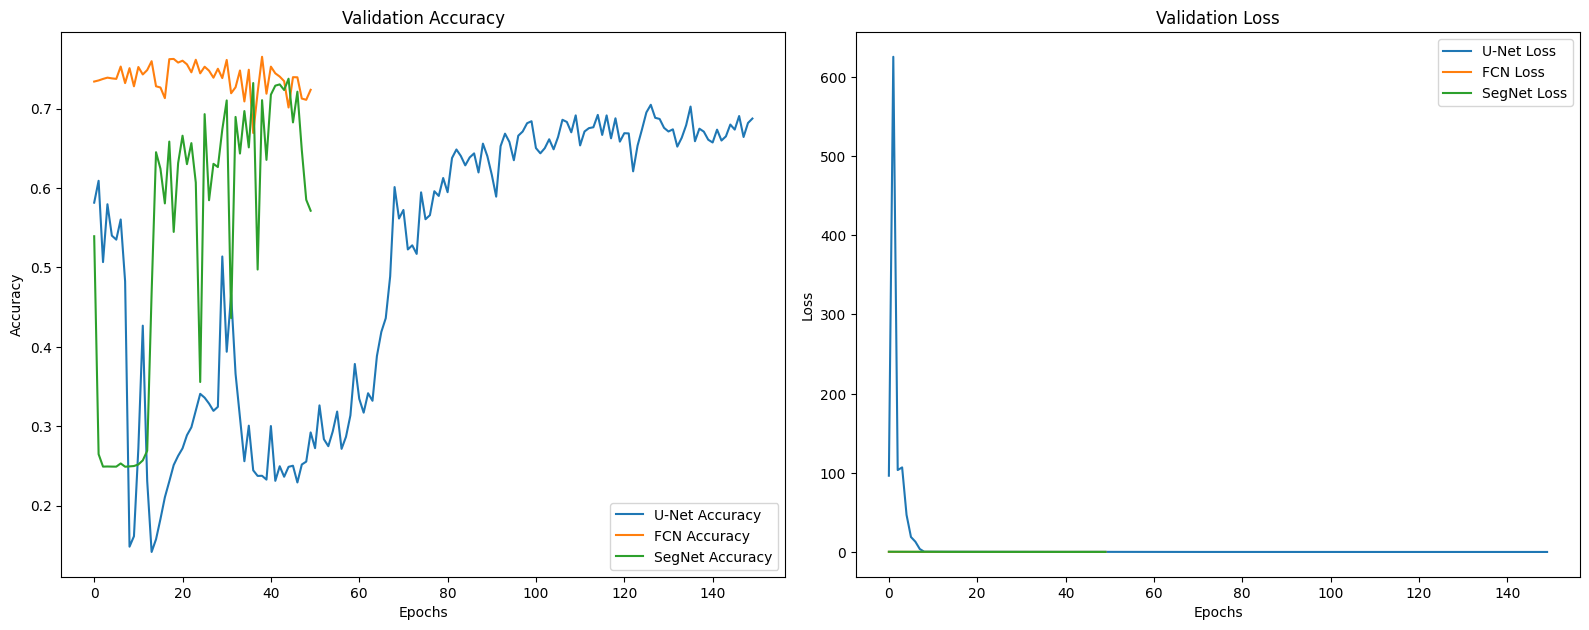

In [ ]:
# Compare performance
plt.figure(figsize=(16, 12))

# Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(retVal.history['val_accuracy'], label='U-Net Accuracy')
plt.plot(history_fcn.history['val_accuracy'], label='FCN Accuracy')
plt.plot(segnet_history.history['val_accuracy'], label='SegNet Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(retVal.history['val_loss'], label='U-Net Loss')
plt.plot(history_fcn.history['val_loss'], label='FCN Loss')
plt.plot(segnet_history.history['val_loss'], label='SegNet Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask




def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, fcn_model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step


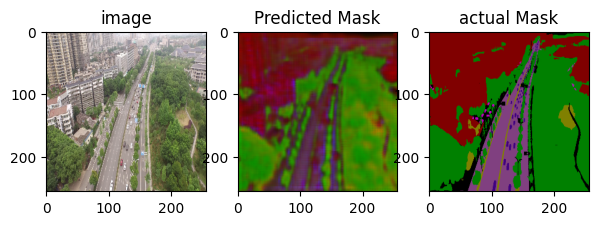

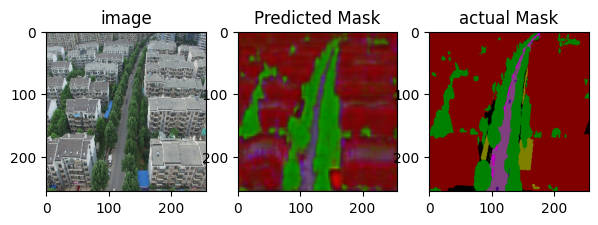

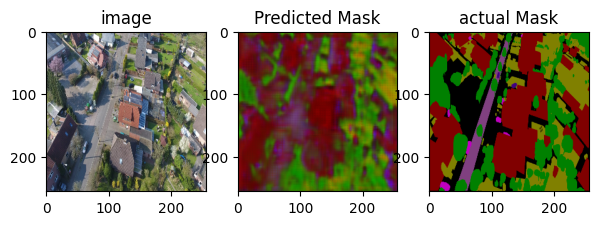

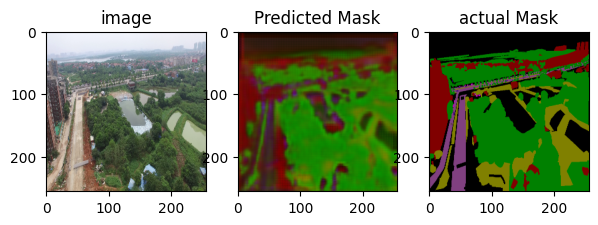

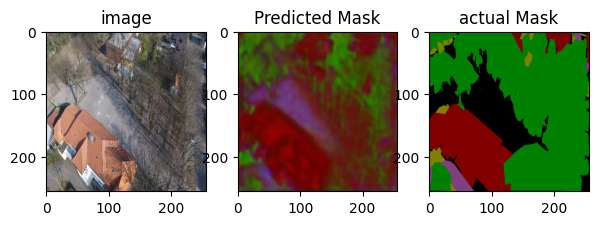

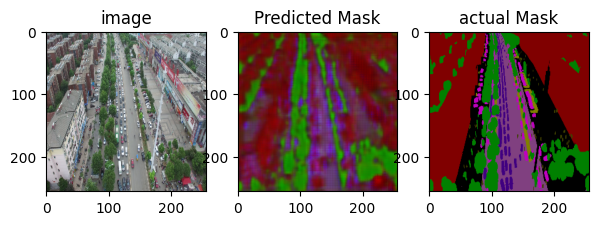

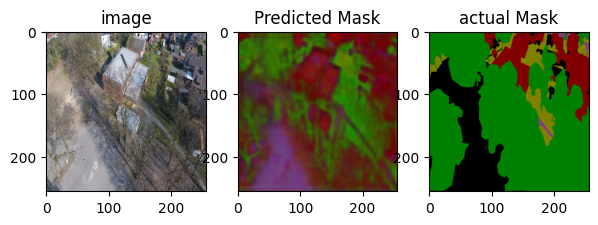

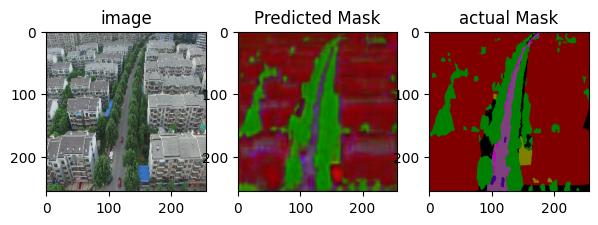

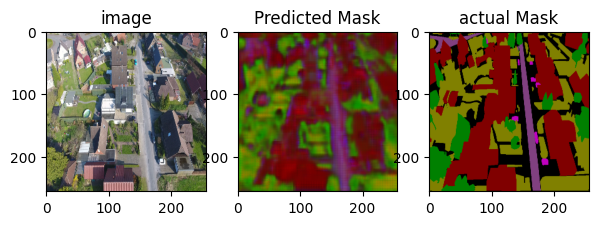

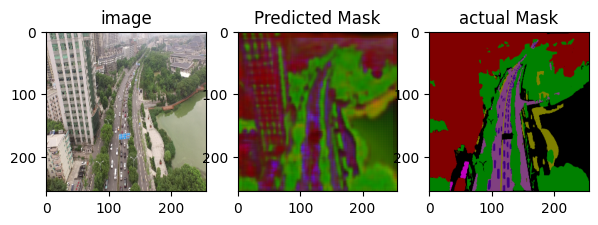

In [ ]:
for i in range(10):
  Plotter(actuals[i], sixteenPrediction[i], masks[i])